In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

In [3]:
!wget https://archive.ics.uci.edu/static/public/15/breast+cancer+wisconsin+original.zip

--2024-04-19 14:27:21--  https://archive.ics.uci.edu/static/public/15/breast+cancer+wisconsin+original.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘breast+cancer+wisconsin+original.zip’

breast+cancer+wisco     [ <=>                ]  84.51K  --.-KB/s    in 0.1s    

2024-04-19 14:27:21 (871 KB/s) - ‘breast+cancer+wisconsin+original.zip’ saved [86541]



In [4]:
!unzip "breast+cancer+wisconsin+original.zip"

Archive:  breast+cancer+wisconsin+original.zip
  inflating: Index                   
  inflating: breast-cancer-wisconsin.data  
  inflating: breast-cancer-wisconsin.names  
  inflating: unformatted-data        
  inflating: wdbc.data               
  inflating: wdbc.names              
  inflating: wpbc.data               
  inflating: wpbc.names              


In [5]:
data_file = 'breast-cancer-wisconsin.data'
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

In [6]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [7]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [8]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

<ipython-input-8-20cbe26a5d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bare_nuclei = pd.to_numeric(df.bare_nuclei)


<Axes: >

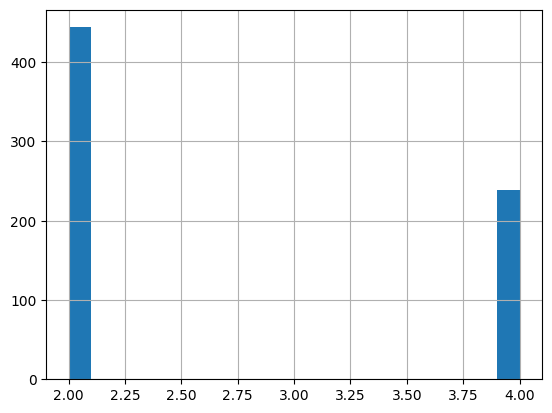

In [9]:
df['class'].hist(bins=20)

In [10]:
df['class'] = np.where(df['class'] == 2, 0, 1)

In [11]:
train, test = train_test_split(df, test_size = 0.2)

In [12]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

In [13]:
train_Y = train.pop("class")
test_Y = test.pop("class")

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [15]:
norm_train_X = norm(train)
norm_test_X = norm(test)

In [19]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [20]:
a = enumerate(train_dataset)

print(len(list(a)))

18


In [41]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [24]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

In [26]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values, y_pred=tf.expand_dims(outputs, axis=-1))
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6819


In [27]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-27-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


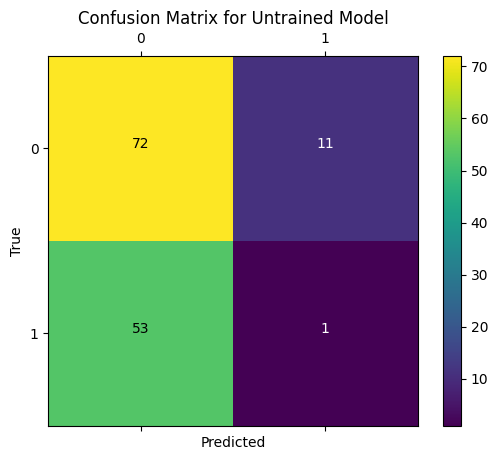

In [28]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

In [29]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''

        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric

        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision

        if self.tp + self.fp == 0:
          precision = 1.0
        else:
          precision = self.tp / (self.tp + self.fp)
        # Calculate recall
        if self.tp + self.fn == 0:
          recall = 1.0
        else:
          recall = self.tp / (self.tp + self.fn)


        # Return F1 Score
        ### START CODE HERE ###
        f1_score = 2 * ((precision * recall) / (precision + recall))
        ### END CODE HERE ###

        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''

        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [30]:
# Test Code:

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()


<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

In [31]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [48]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights

    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    with tf.GradientTape() as tape:
    ### START CODE HERE ###
      logits = model(x)
      loss_value = loss_object(y, logits)
    ### END CODE HERE ###
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return logits, loss_value




In [52]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.

    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        ### START CODE HERE ###
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
        ### END CODE HERE ###

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, dtype=tf.int64)
        #Update the training metrics
        ### START CODE HERE ###
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)
        ### END CODE HERE ###

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))

    return losses

In [54]:

# TEST CODE



test_losses = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=False)

for test_loss in test_losses:
    print(test_loss.numpy())

del test_losses

0.118850514
0.09049106
0.12606227
0.1448499
0.08556137
0.04020092
0.11705766
0.14782242
0.04123809
0.03745883
0.05536762
0.10450165
0.12394286
0.117591426
0.082695834
0.036605455
0.06334397
0.0053184917


In [42]:
len(train.columns)

9

In [55]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)

    return losses


In [56]:
epochs = 9

epochs_val_losses = []
epochs_train_losses = []
for epoch in range(epochs):
  train_losses = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=False)

  train_acc = train_acc_metric.result()
  train_f1 = train_f1score_metric.result()

  val_losses = perform_validation()
  val_acc = val_acc_metric.result()
  val_f1 = val_f1score_metric.result()

  train_loss_mean = np.mean(train_losses)
  val_loss_mean = np.mean(val_losses)
  epochs_train_losses.append(train_loss_mean)
  epochs_val_losses.append(val_loss_mean)

  print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(train_loss_mean), float(val_loss_mean), float(train_acc), float(val_acc), train_f1, val_f1))

  train_acc_metric.reset_states()
  train_f1score_metric.reset_states()
  val_acc_metric.reset_states()
  val_f1score_metric.reset_states()




 Epcoh 0: Train loss: 0.0748  Validation Loss: 0.0778, Train Accuracy: 0.9725, Validation Accuracy 0.9708, Train F1 Score: 0.9597, Validation F1 Score: 0.9636

 Epcoh 1: Train loss: 0.1038  Validation Loss: 0.0743, Train Accuracy: 0.9744, Validation Accuracy 0.9708, Train F1 Score: 0.9626, Validation F1 Score: 0.9636

 Epcoh 2: Train loss: 0.0631  Validation Loss: 0.0741, Train Accuracy: 0.9762, Validation Accuracy 0.9708, Train F1 Score: 0.9653, Validation F1 Score: 0.9636

 Epcoh 3: Train loss: 0.0616  Validation Loss: 0.0747, Train Accuracy: 0.9780, Validation Accuracy 0.9781, Train F1 Score: 0.9679, Validation F1 Score: 0.9725

 Epcoh 4: Train loss: 0.0594  Validation Loss: 0.0783, Train Accuracy: 0.9799, Validation Accuracy 0.9781, Train F1 Score: 0.9707, Validation F1 Score: 0.9725

 Epcoh 5: Train loss: 0.0583  Validation Loss: 0.0756, Train Accuracy: 0.9799, Validation Accuracy 0.9781, Train F1 Score: 0.9707, Validation F1 Score: 0.9725

 Epcoh 6: Train loss: 0.0566  Validatio

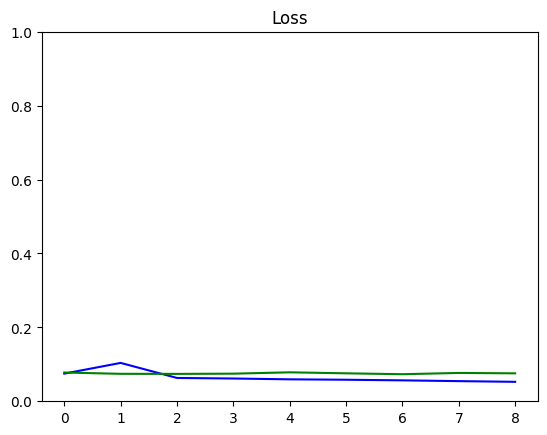

In [57]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

<ipython-input-27-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


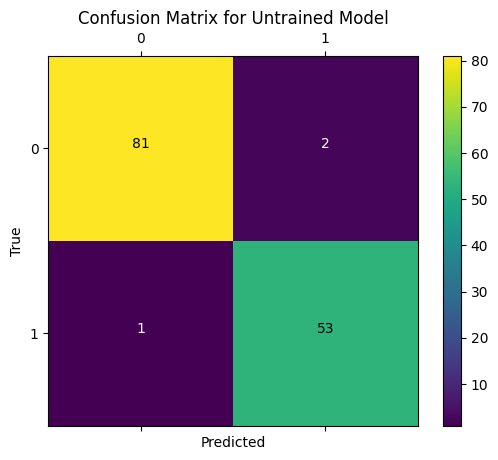

In [58]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')